<a href="https://colab.research.google.com/github/exitcode1984/line_coordinates/blob/main/Line_Coordinates_v2_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hi there!
I tried to add some necesary comments for better understanding.

**Version 2 changes:**
- `cv2.HoughLinesP()` algorithm is being used in order to detect the lines and the coordinates
- Recommended image preprocessing is being added, particularly `cv2.bitwise_not()` and `cv2.GaussianBlur()`
- Implemented dynamic sensitivity adjust for each image detection
- Added docstrings to the functions

### Import Python modules

In [11]:
# Import matplotlib for visualization
import cv2
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import random

from PIL import Image, ImageDraw
import os
import csv
import torch

### Hyperparameters

In [12]:
# Set Hyperparameters
# number of images
SET_SIZE = 100
# the size of 1 image in px
IMG_SIZE = 64
# images directory
IMAGE_DIR = 'linedata'

### Generating coordinates

In [13]:
# set random seed to ensure that results are reproducible.
random.seed(77)

# generating the coordinates
dots = tuple(tuple(random.randint(0,IMG_SIZE-1) for _ in range(4)) for _ in range(SET_SIZE))
# first 5 samples of coordinates (x1, y1, x2, y2)
dots[:5]

((32, 41, 25, 30),
 (24, 14, 37, 60),
 (30, 18, 0, 35),
 (3, 63, 22, 24),
 (49, 23, 42, 41))

In [14]:
# delete a folder and create a new one
!rm -rf linedata
os.mkdir(IMAGE_DIR)

### Coordinates detection

In order to find a line on an image we are going to use HoughLinesP - a popular line detection algorithm of OpenCV library.
OpenCV is a Python library that allows us to perform image processing and computer vision tasks. It provides a wide range of features, including object detection, face recognition, and tracking.


In [15]:
def detect_coordinates(image: np.ndarray) -> tuple[int, int, int, int]:
  """
  Gets an image in ndarray format, does necessary preprocessing and detects a line
  Returns a line coordinates x1_, y1_, x2_, y2_
  """
  # If we had an RGB image, we would use Canny() method instead of inverting it,
  # for preprocessing the image before detecting the lines
  # image = cv2.Canny(image, 50, 200)

  image = cv2.bitwise_not(image)

  # Setting up default values in case we do not detect any line
  x1_, y1_, x2_, y2_ = 0, 0, 0, 0

  # According to the documentation it is advised to blur an image before detecting the lines
  image = cv2.GaussianBlur(image, (3, 3), 0)
  threshold = 5 # starting threshold which we will change in order to adjust the sensitivity
  lines = cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=threshold, minLineLength=3, maxLineGap=2)
  while lines is None or len(lines) != 1:
    threshold += 1
    if lines is not None:
      x1_, y1_, x2_, y2_ = lines[0][0]
    lines = cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=threshold, minLineLength=3, maxLineGap=2)
    if threshold > 200:
      break
  return x1_, y1_, x2_, y2_

In [16]:
# to be added soon
def calculate_the_loss():
  pass

In [17]:
def order_coordinates(coor_list: list, x1: int, y1: int, x2:int, y2: int):
  """
  Assign detected values to correct coordinate (x1, y1) or (x2, y2)
  """
  if abs(coor_list[0] - x1) < abs(coor_list[0] - x2):
    x1_ = coor_list[0]
    x2_ = coor_list[2]
  else:
    x1_ = coor_list[2]
    x2_ = coor_list[0]
  if abs(coor_list[1] - y1) < abs(coor_list[1] - y2):
    y1_ = coor_list[1]
    y2_ = coor_list[3]
  else:
    y1_ = coor_list[3]
    y2_ = coor_list[1]
  return x1_, y1_, x2_, y2_

### Generating images, data table, csv file and saving all the images into IMAGE_DIR folder

In [18]:
# Generating dataset
data_list = []
for i in range(0, SET_SIZE):

  # Generating a new image
  img = Image.new('1', (IMG_SIZE, IMG_SIZE), 'white')
  draw = ImageDraw.Draw(img)
  # Drawing a line with coordinates at dots[i]
  draw.line(dots[i], fill='black', width=1)
  img.save(os.path.join(IMAGE_DIR, str(i) +  '.png'))
  img = cv2.imread(os.path.join(IMAGE_DIR, str(i) + '.png'), 0)

  # Extracting essential data to store it in one place
  # filename, width, height, x1, y1, x2, y2
  x1, y1, x2, y2 = dots[i][0], dots[i][1], dots[i][2], dots[i][3]
  height, width = img.shape
  found_coordinates = detect_coordinates(img)
  x1_, y1_, x2_, y2_ = order_coordinates(found_coordinates, x1, y1, x2, y2)
  # append current data to a temporary list of tuples
  data_list.append((str(i) + '.png', width, height, x1, y1, x2, y2, x1_, y1_, x2_, y2_))


column_name = ['filename', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'x1_', 'y1_', 'x2_', 'y2_']

# Creating a data frame from generated data
img_df = pd.DataFrame(data_list, columns = column_name)

# Save the data into .csv file
img_df.to_csv('dataset.csv', index=None)

# Let's see what we've got
img_df.head()

,filename,width,height,x1,y1,x2,y2,x1_,y1_,x2_,y2_
0,0.png,64,64,32,41,25,30,33,40,25,29
1,1.png,64,64,24,14,37,60,23,15,36,61
2,2.png,64,64,30,18,0,35,31,17,0,35
3,3.png,64,64,3,63,22,24,2,63,23,23
4,4.png,64,64,49,23,42,41,50,22,41,42


### Images and found line coordinates visualization

In [19]:
def get_detected_coordinates(img_filename: str):
  """
  Retrieving detected coordinates from the data frame
  """
  x1_ = int(img_df[img_df.filename==img_filename].iloc[:,7])
  y1_ = int(img_df[img_df.filename==img_filename].iloc[:,8])
  x2_ = int(img_df[img_df.filename==img_filename].iloc[:,9])
  y2_ = int(img_df[img_df.filename==img_filename].iloc[:,10])
  return x1_, y1_, x2_, y2_

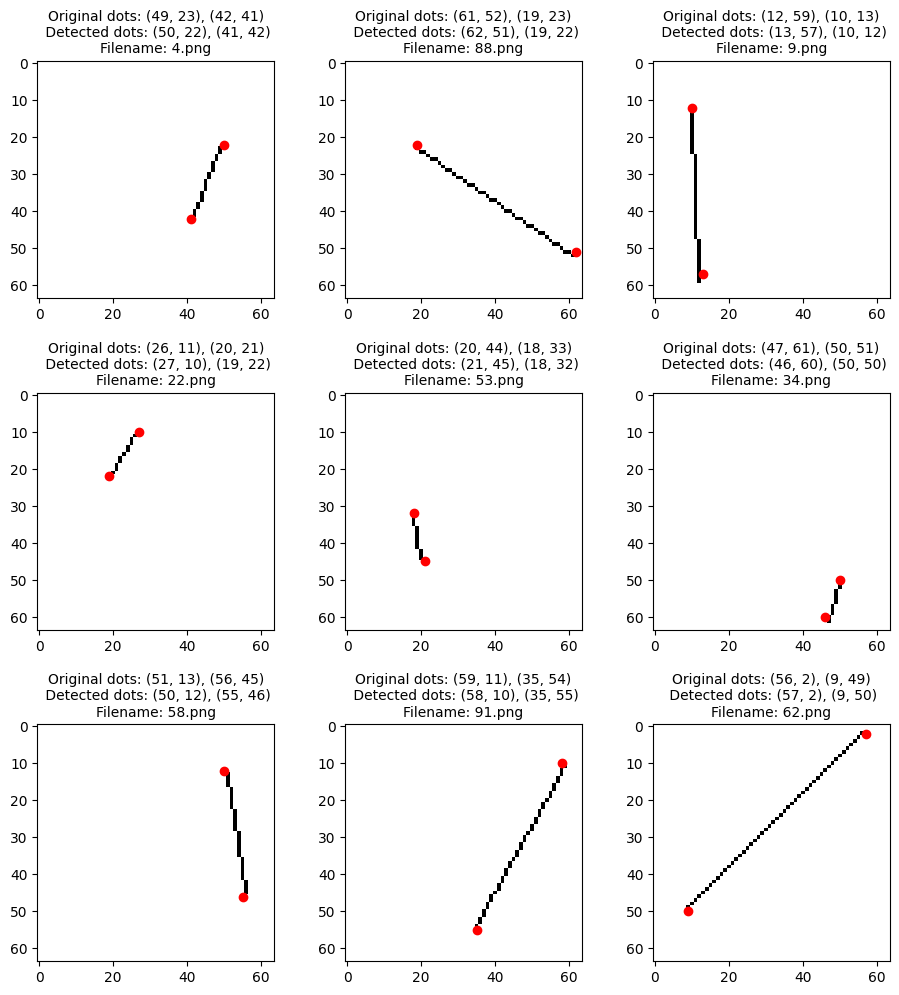

In [25]:
# Visualize random 9 lines with detected coordinates
# torch.manual_seed(78)

# Prepare the visualization settings
fig = plt.figure(figsize=(11, 11))
plt.subplots_adjust(top = 0.9, bottom=0.01, hspace=0.05, wspace=0.3)
rows, cols = 3, 3

# Visualize 1 image per each cell
for i in range(1, rows*cols + 1):

  # Read a random image
  random_idx = torch.randint(0, SET_SIZE, size=[1]).item()
  filename = str(random_idx) + '.png'
  img = Image.open(os.path.join(IMAGE_DIR, filename))

  # Getting initial coordinates
  x1, y1, x2, y2 = dots[random_idx]

  # Getting detected coordinates with a help of a function written above
  x1_, y1_, x2_, y2_ = get_detected_coordinates(filename)

  # Displaying the line
  fig.add_subplot(rows, cols, i)
  plt.imshow(img, cmap='gray')

  # Plotting detected line coordinates by computer vision algorithm
  plt.plot(x1_, y1_, 'ro')
  plt.plot(x2_, y2_, 'ro')

  # Adding title
  plt.title(f'Original dots: ({str(x1)}, {str(y1)}), ({str(x2)}, {str(y2)})\n Detected dots: ({x1_}, {y1_}), ({x2_}, {y2_})\nFilename: {filename}', fontsize=10)